# Overfitting and Model Evaluation
First, credits: many of the examples used come from the brilliant [Peter Prettenhofer](https://twitter.com/pprett) of [DataRobot](http://www.datarobot.com/) and Rob Hall's DAT13 class: https://github.com/hallr/DAT13<br><br>


Third, let's take a minute to discuss [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html), [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [`Polynomial Features`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

# I. Intro: Splitting our dataset into training and testing data.

In [1]:
from sklearn.cross_validation import train_test_split

import pandas as pd

df = pd.DataFrame({
    'X': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'y': [11, 12, 13, 14, 15, 16, 17, 18, 19]
})


X_train, X_test, y_train, y_test = train_test_split(df[['X']], df['y'], test_size=0.3)

df
train_test_split?

In [2]:
# print X_train.values
# print X_test.values

# print y_train.values
# print y_test.values

In [3]:
# X_train, y_train, X_test, y_test = train_test_split(df['X'], df['y'], test_size=0.30)

print "Full dataset:"
print "X = ", df['X'].values
print "y = ", df['y'].values, "\n"

print "Training (\"In-sample\") data:"
print "X_train = ", X_train.values
print "y_train = ", y_train.values, "\n"

print "Test (\"Out-of-sample\") data:"
print "X_test = ", X_test.values
print "y_test = ", y_test.values

# Side note: We can also do the same thing in pandas with df.sample:

# df.sample(frac = .7, random_state = 0).sort()

Full dataset:
X =  [1 2 3 4 5 6 7 8 9]
y =  [11 12 13 14 15 16 17 18 19] 

Training ("In-sample") data:
X_train =  [[9]
 [5]
 [2]
 [6]
 [3]
 [7]]
y_train =  [19 15 12 16 13 17] 

Test ("Out-of-sample") data:
X_test =  [[8]
 [4]
 [1]]
y_test =  [18 14 11]


**Key takeaway:** We need to "hold out" some fraction of our dataset (30% in the above example) to test the results of our model. Above, we held-out 70% of our dataset to fit the model. Once fit, we'll evaluate our model against the test data.

*Test data should be selected randomly to avoid bias*

## II. Model Complexity and the problem of overfitting

[Polynomial regression](http://en.wikipedia.org/wiki/Polynomial_regression) fits a n-th order polynomial to our data using least squares. 

[Linear regression](http://en.wikipedia.org/wiki/Linear_regression) is a special case of polynomial regression which fits a polynomial of degree=1.
<br>

To apply Polynomial regression, we add additional features for each of the higher-order polynomial terms. To illustrate:

Suppose we have a dataset with features $x_1$, $x_2$ and target variable $y$. We could apply polynomial regression for a 2nd order polynomial by adding additional features $x_1^2, x_2^2, x_1 x_2$

In other words, in the linear case we are fitting:

$y = \boldsymbol\beta_1 x_1 + \boldsymbol\beta_2 x_2$

And we're just adding additional features for the polynomial terms to our model:

$y = \boldsymbol\beta_1 x_1 + \boldsymbol\beta_2 x_2 + \boldsymbol\beta_3 x_1^2 + \boldsymbol\beta_4 x_2^2 + \boldsymbol\beta_5 x_1 x_2$


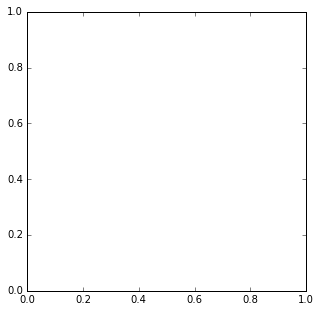

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

figsize(5,5)
np.random.seed(9)

# A simple sinusoidal function
def f(x):
    return np.sin(2 * np.pi * x)

# generate points along x used to plot

# np.linspace(lower_bound, upper_bound, n_samples)
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100

# In your own words, what do you think np.random.uniform does?
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]

# y = sin(2pi * x) + randomness
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

fig, axes = plt.subplots(1,1)

def plot_scatter(X_train, y_train, ax):
    ax.plot(x_plot, f(x_plot), label='ground truth: sin(2pi*x)', color='green')
    ax.scatter(X_train, y_train, label='Training Data', s=100)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')

    ax.legend();

In [16]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_train, y_train, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right', frameon=True)

In [17]:
# fig, ax = plt.subplots(1,1)
# degree = 1

# Step 1: Transform my input into a Polynomial feature space:

# Example Input
#     x = [1, 3, 4, 2, 3]
#
# x_poly_features = PolynomialFeatures(degree=2)
# x_poly_features.fit_transform(x)
#
# Example output:
#        interc. x   x^2
# array([[ 1,  1,  1],
#        [ 1,  3,  9],
#        [ 1,  4, 16],
#        [ 1,  2,  4],
#        [ 1,  3,  9]])


## Stage 1: Add a 2nd order term (PolynomialFeatures(degree=2))
interc = np.ones_like(X_train)
x = X_train
x_sq = X_train * X_train

X_train_2 = np.concatenate([interc, x, x_sq], axis=1)

from sklearn.linear_model import LinearRegression

# Stage 2: Fit the model
model = LinearRegression()
model.fit(X_train_2, y_train)

# model.coef_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Test r-squared:  0.505729466497
Train r-squared:  0.534147413644


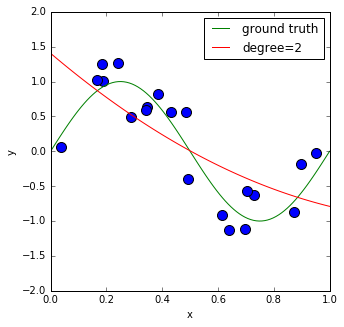

In [18]:
fig, ax = plt.subplots(1,1)

degree = 2

# Step 2: Apply Linear Regression
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train, y_train)

plot_approximation(est, ax, label='degree=%d' % degree)

score_test = est.score(X_test, y_test)
score_train = est.score(X_train, y_train)

print "Test r-squared: ", score_test
print "Train r-squared: ", score_train

### Q: Qualitatively, how would you characterize this fit?

### Your turn:
Plot the fit of a polynomial of degree 3:

In [35]:

degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

def fit_degree(degree):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

#     X_poly_features = PolynomialFeatures(degree).fit(X_train)
#     LinearRegression().fit(X_poly_features, y_train)
    
    est.fit(X_train, y_train)
    
    plot_approximation(est, ax, label='degree=%d' % degree)

    score_test = est.score(X_test, y_test)
    score_train = est.score(X_train, y_train)

    print "\ndegree: %s"% degree
    print "Train r-squared: ", score_train
    print "Test r-squared: ", score_test

    
for degree in degrees:
    fit_degree(degree)


degree: 2
Train r-squared:  0.534147413644
Test r-squared:  0.505729466497

degree: 3
Train r-squared:  0.872765894358
Test r-squared:  0.815863755519

degree: 4
Train r-squared:  0.875149752928
Test r-squared:  0.815089775898

degree: 5
Train r-squared:  0.875266252148
Test r-squared:  0.817791888312

degree: 6
Train r-squared:  0.877390356261
Test r-squared:  0.816388457285

degree: 7
Train r-squared:  0.897558021565
Test r-squared:  0.545872315898

degree: 8
Train r-squared:  0.900606110864
Test r-squared:  0.620458454444

degree: 9
Train r-squared:  0.939807695936
Test r-squared:  -5.42261465764

degree: 10
Train r-squared:  0.940079430235
Test r-squared:  -3.63940077929

degree: 11
Train r-squared:  0.94009430166
Test r-squared:  -4.81354660715


Plot the fit of a polynomial of degree 3:

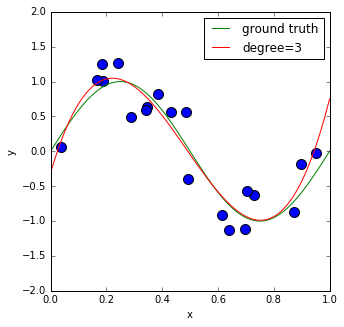

In [32]:
fig, ax = plt.subplots(1,1)
degree = 3

# Step 2: Apply Linear Regression
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

est.fit(X_train, y_train)
plot_approximation(est, ax, label='degree=%d' % degree)

Plot the fit of a polynomial of degree 9:

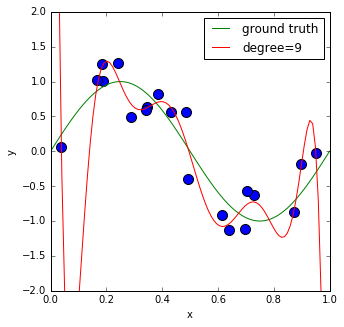

In [33]:
fig, ax = plt.subplots(1,1)
degree = 9

# Step 2: Apply Linear Regression
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

est.fit(X_train, y_train)
plot_approximation(est, ax, label='degree=%d' % degree)

### Q: What happens as we increase the degree of polynomial?

### Q: Which polynomial should we choose? 

array([[ 0.28929928],
       [ 0.87340084],
       [ 0.18735865],
       [ 0.49192894],
       [ 0.63805398],
       [ 0.43004681],
       [ 0.16677635],
       [ 0.38647717],
       [ 0.72908562],
       [ 0.34549864],
       [ 0.61493248],
       [ 0.03857092],
       [ 0.69773639],
       [ 0.34280523],
       [ 0.95096403],
       [ 0.48449846],
       [ 0.24311568],
       [ 0.89800712],
       [ 0.18315273],
       [ 0.70242742]])

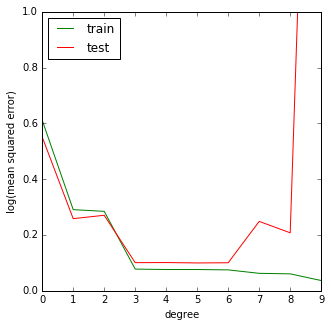

In [39]:
from sklearn.metrics import mean_squared_error

degrees=10

train_error = np.empty(degrees)
test_error = np.empty(degrees)
for degree in range(degrees):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

plt.plot(np.arange(degrees), train_error, color='green', label='train')
plt.plot(np.arange(degrees), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left');

est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)

# Difference between actual and predicted
residual_test_error = y_test - est.predict(X_test)
                      
# squared_error = np.dot(residual_error, residual_error)

The higher the degree of the polynomial (our proxy for model complexity), the lower the training error. The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven. 

This phenomenon is called *overfitting*: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. So when we get some data, we could fit a bunch of polynomials and then choose the one that minimizes MSE.

##### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

### Cost function: Mean square error

#### Linear Regression:
$J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2$
  
#### Regularized Linear Regression:
  
  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$
  


where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

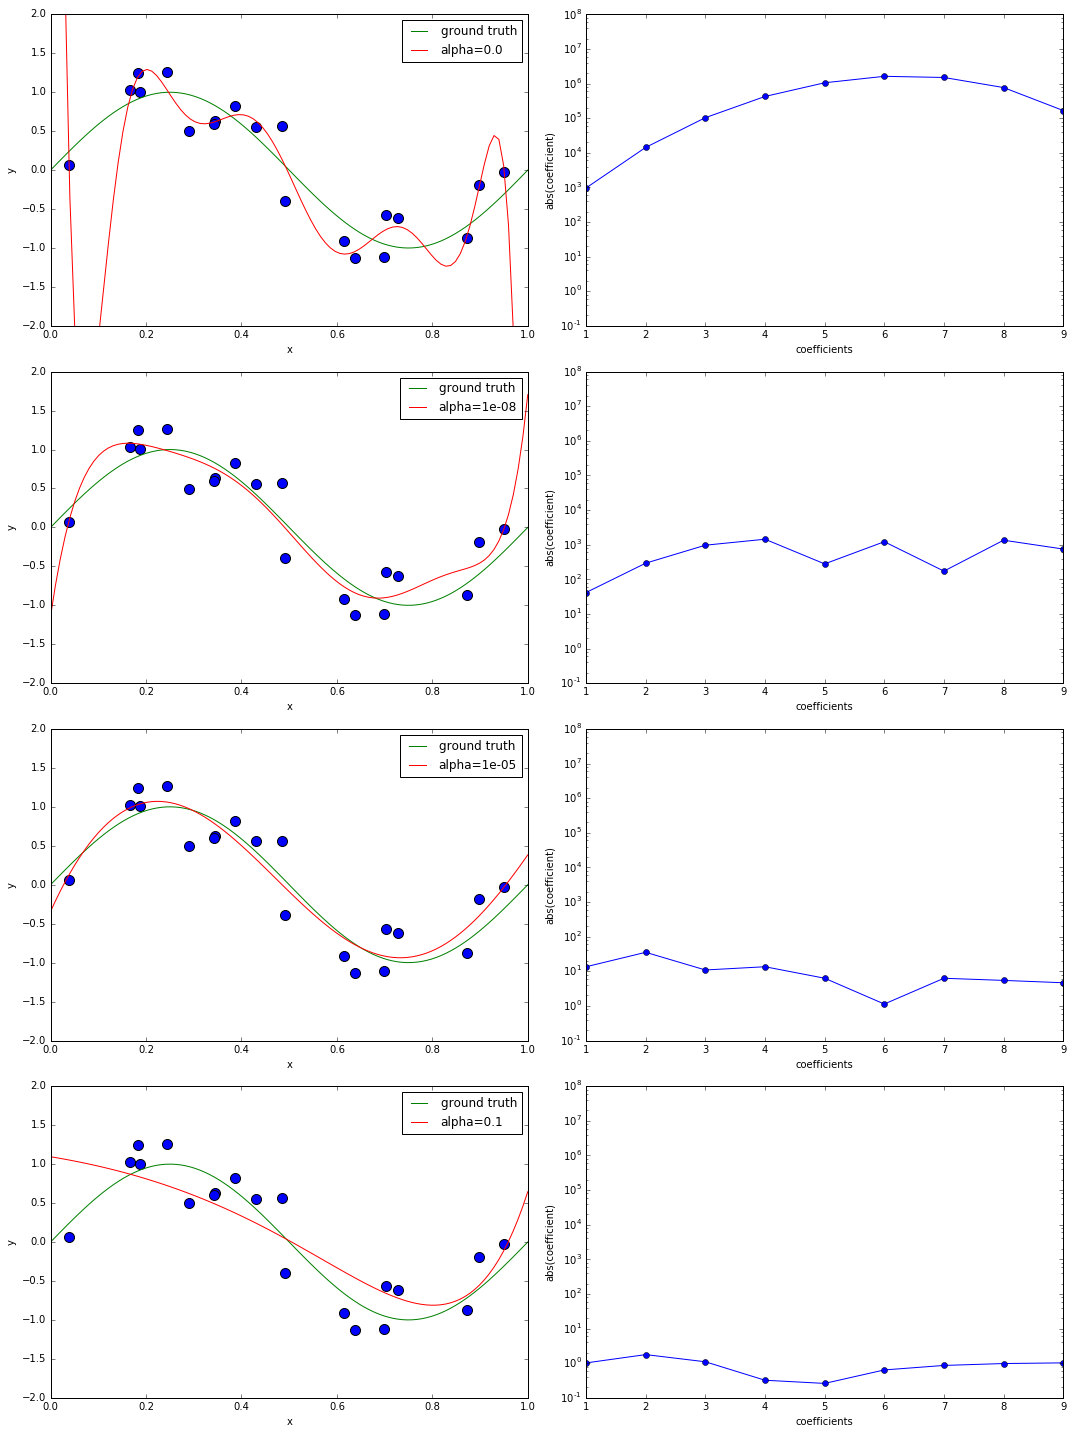

In [37]:
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)



    
plt.tight_layout()

## III. Regularization techniques

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. Another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

/Users/Aerlinger/.pyenv/versions/2.7.11/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


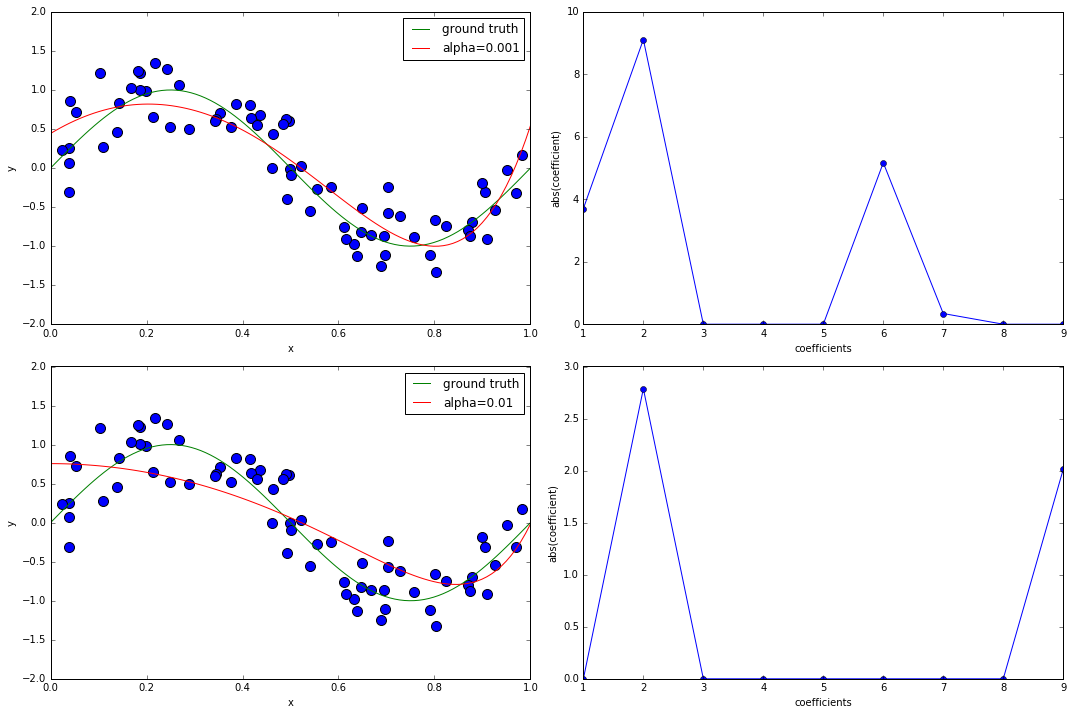

In [13]:
from sklearn.linear_model import Lasso

fig, ax_rows = plt.subplots(2, 2, figsize=(15, 10))

degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

## Further Exercise (Optional, but recommended)

A criminologist studying the relationship between income level and assults in U.S. cities (among other things) collected the following data for 2215 communities. The dataset can be found in the [UCI machine learning site](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized).

We are interested in the per capita assult rate and its relation to median income.

In [14]:
crime = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt", 
                    header = None, na_values  = '?',
                    names = ['communityname', 'state', 'countyCode', 'communityCode', 'fold', 'population', 'householdsize', 
                             'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 
                             'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 
                             'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 
                             'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 
                             'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 
                             'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 
                             'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 
                             'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 
                             'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 
                             'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 
                             'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 
                             'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 
                             'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 
                             'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 
                             'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'OwnOccQrange', 'RentLowQ', 'RentMedian', 
                             'RentHighQ', 'RentQrange', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 
                             'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 
                             'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 
                             'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 
                             'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 
                             'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
                             'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 
                             'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 
                             'murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 
                             'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 
                             'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'])

1. Fit a simple linear regression model to the data with `np.log(crime.assaults)` as the dependent variable and `np.log(crime.medIncome)` as the independent variable. Plot the estimated regression line.

4. Test whether there is a linear relationship between `assaults` and `medIncome` at level $\alpha=0.05$. State the null hypothesis, the alternative, the conclusion and the $p$-value.

5. Give a 95% confidence interval for the slope of the regression line. Interpret your interval.

6. Report the $R^2$ and the adjusted $R^2$ of the model, as well as an estimate of the variance of the errors in the model.

7. Go to [archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized) and pick out a few other factors that might help you predict `assults`.